# Regression using a CNN


Deep learning models can be a good alternative to traditional machine learning models in this problem because they can do feature selection automatically while learning the time-dependency of the data.


For this project we will use Pytorch due to its flexibility. The idea is to create a 1D CNN network that works as follows:


<img src="./figures/CNN_methods.png" alt="deep learning architecture" width="600"/>


In [7]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import matplotlib.pyplot as plt

In [3]:
class CNN(nn.Module):
    def __init__(self, input_channels, cnn_filters) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, cnn_filters, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(cnn_filters, cnn_filters, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(cnn_filters, out_channels=cnn_filters, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.5),
            nn.Conv1d(cnn_filters, 3, kernel_size=3),
            nn.AdaptiveAvgPool1d(1),
        )

    def forward(self, x):
        x = self.features(x)
        return x.squeeze(-1)

In [ ]:
class CNCDataset(Dataset):
    def __init__(self, data_dir, wear_file, scaler=None, max_seq_length=None):
        self.data_dir = data_dir
        self.scaler = scaler
        self.max_seq_length = max_seq_length
        self.wear_data = pd.read_csv(wear_file).drop("cut", axis=1).values
        self.signal_files = sorted(
            [f for f in os.listdir(data_dir) if f.endswith(".csv")]
        )

    def __len__(self):
        return len(self.signal_files)

    def __getitem__(self, idx):
        signal_file = os.path.join(self.data_dir, self.signal_files[idx])
        signal_df = pd.read_csv(signal_file)
        signals = signal_df.values

        if self.scaler:
            signals = self.scaler.transform(signals)

        signals_tensor = torch.tensor(signals, dtype=torch.float32).permute(1, 0)
        # Padding to max sequence length
        if self.max_seq_length is not None:
            padding_size = self.max_seq_length - signals_tensor.shape[1]
            if padding_size > 0:
                signals_tensor = torch.nn.functional.pad(
                    signals_tensor, (0, padding_size)
                )

        wear_target = torch.tensor(self.wear_data[idx], dtype=torch.float32).squeeze()

        return {
            "signals": signals_tensor,
            "wear_target": wear_target,
        }


def load_and_preprocess_signals(data_dir):
    all_signals = []
    max_seq_length = 0
    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            signal_data = pd.read_csv(os.path.join(data_dir, file)).values
            all_signals.append(signal_data)
            max_seq_length = max(max_seq_length, signal_data.shape[0])
    all_signals = np.vstack(all_signals)
    return all_signals, max_seq_length

In [ ]:
def train_one_epoch(
    model, data_loader, criterion, optimizer, device, accumulation_steps=4
):
    model.train()
    epoch_loss = 0.0

    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        signals = batch["signals"].to(device)
        wear_target = batch["wear_target"].to(device)

        output = model(signals)

        loss = criterion(output, wear_target)
        loss.backward()

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)


def validate_one_epoch(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0.0

    with torch.no_grad():
        for batch in data_loader:
            signals = batch["signals"].to(device)
            wear_target = batch["wear_target"].to(device)

            output = model(signals)

            loss = criterion(output, wear_target)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)


def save_model(model, epoch, path="model.pth"):
    torch.save({"epoch": epoch, "model_state_dict": model.state_dict()}, path)


In [8]:
# Set up data, model, optimizer, and loss
train_data_dir = "../data/raw/c1/c1"
train_wear_file = "../data/raw/c1/c1_wear.csv"
valid_data_dir = "../data/raw/c4/c4"
valid_wear_file = "../data/raw/c4/c4_wear.csv"


train_signals, max_seq_length_train = load_and_preprocess_signals(train_data_dir)
# scaler = MinMaxScaler(feature_range=(0, 1)) # StanddardScaler worked better here
scaler = StandardScaler()
scaler.fit(train_signals)

train_dataset = CNCDataset(
    data_dir=train_data_dir,
    wear_file=train_wear_file,
    scaler=scaler,
    max_seq_length=max_seq_length_train,
)
valid_dataset = CNCDataset(
    data_dir=valid_data_dir,
    wear_file=valid_wear_file,
    scaler=scaler,
    max_seq_length=max_seq_length_train,
)


In [9]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(input_channels=7, cnn_filters=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.8, patience=10, verbose=True
)
criterion = nn.MSELoss()

num_epochs = 500
save_interval = 10

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss = validate_one_epoch(model, valid_loader, criterion, device)

    scheduler.step(valid_loss)

    # Save the model only every 50 epochs
    if (epoch + 1) % save_interval == 0:
        save_path = f"model_epoch_{epoch+1}.pth"
        save_model(model, epoch, save_path)
        print(f"Model saved at epoch {epoch+1}")

    epoch_duration = time.time() - start_time
    minutes, seconds = divmod(epoch_duration, 60)

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Learning Rate: {optimizer.param_groups[0]['lr']:.3f}, Time: {int(minutes)} min {int(seconds)} sec"
    )

OutOfMemoryError: CUDA out of memory. Tried to allocate 312.00 MiB (GPU 0; 5.61 GiB total capacity; 4.44 GiB already allocated; 118.00 MiB free; 4.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Training had to be run from the command-line with everything else closed to save gpu memory


## Evaluating performance


Loading the model at the last epoch of the training process


In [ ]:
def load_latest_model(model, model_dir, device):
    model_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]

    if not model_files:
        raise ValueError("No model files found in the directory!")

    # Extract the epoch number from the file names (assuming format 'model_epoch_X.pth')
    model_epochs = [int(f.split("_epoch_")[1].split(".")[0]) for f in model_files]

    latest_epoch = max(model_epochs)
    latest_model_file = f"model_epoch_{latest_epoch}.pth"

    model_path = os.path.join(model_dir, latest_model_file)
    checkpoint = torch.load(model_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    print(f"Loaded model from {latest_model_file} (Epoch {checkpoint['epoch']})")

    return model


model_dir = (
    "./weights/lr0.002p0.5/"  # Replace with the directory containing the saved models
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(input_channels=7, cnn_filters=128).to(device)

model = load_latest_model(model, model_dir, device)

Loaded model from model_epoch_500.pth (Epoch 499)


In [ ]:
def run_inference(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            signals = batch["signals"].to(device)

            output = model(signals)

            predictions.append(output.cpu().numpy())

    predictions = np.vstack(predictions)

    return predictions

In [ ]:
def plot_true_vs_pred(true_vals, pred_vals, flute):
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)

    plt.figure(figsize=(10, 6))

    plt.plot(
        true_vals[:, flute - 1],
        label=f"True wear on flute {flute}",
        linestyle="-",
        marker="o",
    )
    plt.plot(
        pred_vals[:, flute - 1],
        label=f"Predicted wear on flute {flute}",
        linestyle="--",
        marker="x",
    )

    plt.title("True vs Predicted Wear Values for Each Flute")
    plt.xlabel("Cut")
    plt.ylabel(r"Wear $(\mu m)$")
    plt.legend()
    plt.grid(True)
    plt.show()

Select here the dataset to compare against


In [ ]:
test_data_dir = "../data/raw/c1/c1"
test_wear_file = "../data/raw/c1/c1_wear.csv"

test_dataset = CNCDataset(
    data_dir=test_data_dir, wear_file=test_wear_file, scaler=scaler
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [19]:
predictions = run_inference(model, test_loader, device)

In [ ]:
real_wear_data = pd.read_csv(test_wear_file).drop("cut", axis=1).values

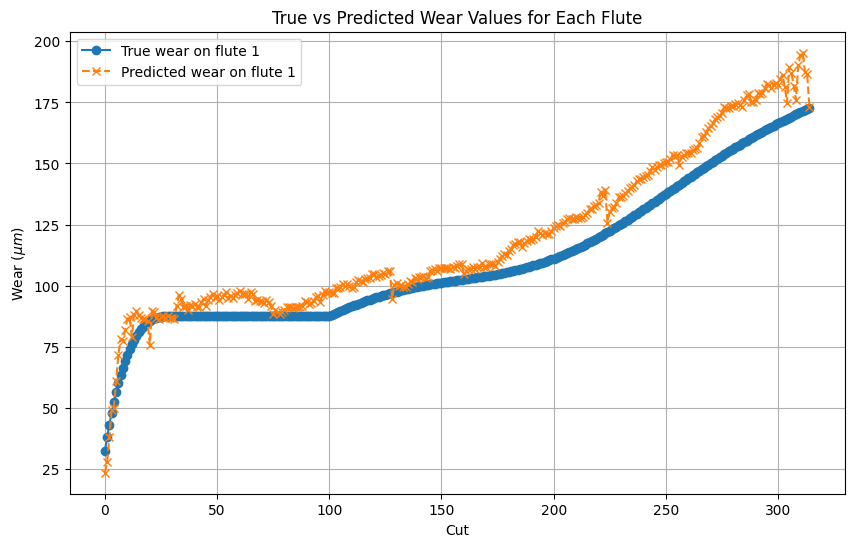

In [21]:
plot_true_vs_pred(real_wear_data, predictions, 1)

## Exporting all the data for Dashboard


In [44]:
streamlit_data = df = pd.DataFrame()

In [ ]:
streamlit_data[["c1w1", "c1w2", "c1w3"]] = real_wear_data

In [ ]:
streamlit_data[["c1w1p", "c1w2p", "c1w3p"]] = predictions

In [ ]:
test_data_dir = "../data/raw/c4/c4"  # Directory with test signals
test_wear_file = (
    "../data/raw/c4/c4_wear.csv"  # Wear data file (if you have true labels for testing)
)

test_dataset = CNCDataset(
    data_dir=test_data_dir, wear_file=test_wear_file, scaler=scaler
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [49]:
predictions = run_inference(model, test_loader, device)

In [ ]:
real_wear_data = pd.read_csv(test_wear_file).drop("cut", axis=1).values

In [ ]:
streamlit_data[["c4w1", "c4w2", "c4w3"]] = real_wear_data

In [ ]:
streamlit_data[["c4w1p", "c4w2p", "c4w3p"]] = predictions

In [ ]:
test_data_dir = "../data/raw/c6/c6"  # Directory with test signals
test_wear_file = "../data/raw/c6/c6_wear.csv"

test_dataset = CNCDataset(
    data_dir=test_data_dir, wear_file=test_wear_file, scaler=scaler
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [54]:
predictions = run_inference(model, test_loader, device)

In [ ]:
real_wear_data = pd.read_csv(test_wear_file).drop("cut", axis=1).values

In [ ]:
streamlit_data[["c6w1", "c6w2", "c6w3"]] = real_wear_data

In [ ]:
streamlit_data[["c6w1p", "c6w2p", "c6w3p"]] = predictions

In [58]:
streamlit_data

,c1w1,c1w2,c1w3,c1w1p,c1w2p,c1w3p,c4w1,c4w2,c4w3,c4w1p,c4w2p,c4w3p,c6w1,c6w2,c6w3,c6w1p,c6w2p,c6w3p
0,32.317114,48.892617,37.720825,23.420475,44.299381,24.171932,31.416355,19.483692,21.748063,26.863510,36.713753,21.126871,62.788648,9.896641,14.620908,21.085661,40.999676,22.941429
1,37.914879,49.570815,37.720825,27.844791,41.786125,23.518147,34.892770,23.473047,24.925960,26.863510,36.713753,21.126871,64.136043,19.793281,29.241817,29.064751,38.412720,23.279652
2,43.087910,50.302867,37.720825,38.000107,52.011063,33.353523,38.102847,27.172868,27.898659,31.824238,41.943176,24.806324,65.365273,29.689922,43.862725,47.821728,50.978939,35.718540
3,47.859072,51.083652,37.849851,49.178394,60.924946,42.790768,41.061023,30.599309,30.677848,42.950371,50.058624,32.509777,66.486880,39.586563,58.483634,65.096748,61.681976,47.257122
4,52.250329,51.908288,38.172665,49.897404,59.135994,45.793648,43.781191,33.767870,33.274721,39.640511,50.769463,34.618057,67.510808,43.019994,59.345759,70.246017,67.013100,52.954510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,170.981042,161.824508,155.546719,194.280960,181.091476,175.234360,191.527141,206.633895,198.454237,161.708176,150.537170,143.791687,179.294708,228.994989,234.082608,274.746429,269.330688,278.061584
311,171.411854,162.517989,156.189184,195.334518,182.099930,176.270126,192.696201,207.724013,199.396303,160.788300,149.192886,141.676697,179.426166,230.164801,234.240943,319.431122,319.049652,334.368774
312,171.839631,163.218075,156.844309,187.430618,174.664383,168.645386,193.859049,208.801783,200.326329,161.666077,149.289810,140.314011,179.436528,231.334613,234.399278,318.129456,317.815796,332.767303
313,172.264561,163.924726,157.512083,186.426453,174.565506,169.445877,195.015359,209.866976,201.244141,167.204865,153.711151,142.457687,179.436528,232.504425,234.557613,321.377655,321.239441,336.235291


In [59]:
streamlit_data.to_csv("DL_C1.csv", index=False)